# Introduction

>

# Importing the libraries and setting default values

In [105]:
!pip3 install xgboost
!pip3 install flair
!pip3 install swifter

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
  Using cached flair-0.4.1.tar.gz (78 kB)
    ERROR: Command errored out with exit status 1:
     command: /Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/h1/t6f6hhhj5l51rmq8frg64jj00000gn/T/pip-install-9oFM

In [106]:


import pandas as pd
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import stats
from scipy.stats import variation
from os import listdir
from os.path import isfile, join
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.proportion import proportions_ztest
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import  Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import utils
import os
import multiprocessing as mp
import xgboost as xgb
label_encoder = LabelEncoder()
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform
from scipy.spatial import distance
import pylab
import matplotlib
import warnings
# import boto3
import pickle
# import boto3.session
# import swifter
# from sagemaker import get_execution_role

# import flair
# from flair.embeddings import FlairEmbeddings, BertEmbeddings, WordEmbeddings, DocumentRNNEmbeddings


warnings.simplefilter('ignore')

# Below are the values that are set as default values for the figures in this report.  
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)
sns.set(font_scale = 1.5)

%matplotlib inline 

In [107]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 150)

In [108]:

# # init Flair embeddings
# flair_forward_embedding = FlairEmbeddings('multi-forward')
# flair_backward_embedding = FlairEmbeddings('multi-backward')

# # init BERT base (cases)
# optional_embedding = BertEmbeddings('bert-base-cased')
# # OR init ELMo (original)
# # optional_embedding = ELMoEmbeddings('original')

# word_embeddings = list(filter(None, [
#     optional_embedding,
#     FlairEmbeddings('news-forward'),
#     FlairEmbeddings('news-backward'),
# ]))

# # Initialize document embedding by passing list of word embeddings
# document_embeddings = DocumentRNNEmbeddings(
#     word_embeddings,
#     hidden_size=512,
#     reproject_words=True,
#     reproject_words_dimension=256,
# )

# flair_sentiment = flair.models.TextClassifier.load('en-sentiment')


In [109]:
def flair_for_column(x):
    '''
    Input: The string of the sentence.
    Output: Score
    '''
    x = flair.data.Sentence(x)
    flair_sentiment.predict(x)
    total_sentiment = x.labels
    try:
        sentiments = [total_sentiment[0].score * (-1,1)[str(total_sentiment[0]).split()[0].startswith("POS")] ]
        return sentiments[0]
    except:
        return np.nan


 

# Extract, Transfrom, Load (ETL) data

### Questionaire dataset

In [110]:
AWS = 1
bucket='insightdata-zahra'
if AWS:
    cred = boto3.Session().get_credentials()
    ACCESS_KEY = cred.access_key
    SECRET_KEY = cred.secret_key
    SESSION_TOKEN = cred.token  ## optional

    s3client = boto3.client('s3', 
                            aws_access_key_id = ACCESS_KEY, 
                            aws_secret_access_key = SECRET_KEY, 
                            aws_session_token = SESSION_TOKEN
                           )

In [421]:


path_data = '../../data/processed/'
path_pickle = '../../data/pickles/'
data_key = 'DATATOUSEwarehouse_03_14_20forZahra.csv'
pickle_key='New_dataframe_Questionnaire.pkl'
data_location_AWS = 's3://{}/{}'.format(bucket, data_key)
pickle_location_AWS = 's3://{}/{}'.format(bucket, pickle_key)
data_location_local = path_data+data_key
pickle_location_local = path_pickle+pickle_key
try:
    if ~AWS:
        with open(pickle_location_local, 'rb') as file:
            df = pickle.load(file)
            file.close()
        print('Loading pickle ...')
    elif AWS:
        response = s3client.get_object(Bucket=bucket, Key=pickle_key)
        body = response['Body'].read()
        df = pickle.loads(body)
        print('Loading pickle ...')            
except:
    print('Loading data ...')
    if ~AWS:
        df=pd.read_csv(data_location_local)
    elif AWS:
        df=pd.read_csv(data_location_AWS)            
    # rename the columns' names and remove the text that accompany some of the columns' names
    clp = df.columns.str.extract("(\S{2}_\d{1,})")
    df.rename(columns = dict(zip(df.columns[5:65].values,clp[5:65].values[:,0])),inplace=True)    
    print('Feature engineering ...')

    df['ti_Overall'] = df['ti_60']>3
    df['ti_positive'] = (df.iloc[:,5:65]>3).sum(axis=1)
    df['ti_negative'] = ((df.iloc[:,5:65]>0)&(df.iloc[:,5:65]<3)).sum(axis=1)
    df['ti_inconsistent'] = (df.iloc[:,5:65]==3).sum(axis=1)
    
    df['E-Score'] = df['ti_positive']/(df['ti_positive']+df['ti_inconsistent']+df['ti_negative'])

    df['Target'] = df['E-Score']>np.median(df['E-Score'])

    df['#Responses'] = df['ti_inconsistent']+df['ti_positive']+df['ti_negative']

    df['LeftAt'] = df.iloc[:,5:65].iloc[:,::-1].cumsum(axis = 1).iloc[:,::-1].idxmin(axis = 1).str.extract("\S{2}_(\d{1,})").astype('int')

        print('Sentiment analysis ...')    
        df['ti_unique_score0'] = df['ti_unique'].str.strip().dropna().swifter.apply(flair_for_column)
        df['ti_unique_score'] = pd.cut(df['ti_unique_score0'].dropna(), bins=5, labels= np.arange(1,6)).astype('int')
        df['ti_unique_score'] = df['ti_unique_score'].fillna(0).astype('int')

        df['ti_change_score0'] = df['ti_change'].str.strip().dropna().swifter.apply(flair_for_column)
        df['ti_change_score'] = pd.cut(df['ti_change_score0'].dropna(), bins=5, labels= np.arange(1,6)).astype('int')
        df['ti_change_score'] = df['ti_change_score'].fillna(0).astype('int')
    print('Creating pickle...')
    if ~AWS:
        df.to_pickle(pickle_location_local)
    elif AWS:
        df.to_pickle(pickle_key)
        s3_resource = boto3.resource('s3')
        s3_resource.Object(bucket,pickle_key).put(Body=open(pickle_key, 'rb'))


Loading data ...
Feature engineering ...
Creating pickle...


In [240]:
df

,Survey,id,participant,Survey Code,started,ti_1,ti_2,ti_3,ti_4,ti_5,...,Team,ti_Overall,E-Score,Target,#Responses,LeftAt,ti_unique_score0,ti_unique_score,ti_change_score0,ti_change_score
0,1,103695,345311,43233,True,4,5,3,1,3,...,NaN,False,0.150000,False,60,60,0.997186,5,NaN,0
1,1,103453,345291,90973,True,5,5,5,5,5,...,NaN,True,0.983333,False,60,60,0.961723,5,0.996042,5
2,1,114433,345282,15724,True,0,0,0,0,0,...,NaN,False,NaN,False,0,1,NaN,0,NaN,0
3,1,110803,345297,84210,True,5,5,5,4,4,...,NaN,True,0.900000,False,60,60,-0.997911,1,-0.965105,1
4,1,112815,345272,75834,True,4,5,4,4,4,...,NaN,True,1.000000,False,60,60,0.999004,5,0.980359,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357687,219,313018,554309,MC121271,True,3,3,3,3,3,...,NaN,False,0.100000,False,60,60,0.999032,5,0.990351,5
357688,219,313028,554324,HA070574,True,3,5,3,5,5,...,NaN,True,0.750000,False,60,60,NaN,0,0.997961,5
357689,219,312974,554258,CH081394,True,5,5,5,5,5,...,NaN,True,1.000000,False,60,60,NaN,0,NaN,0
357690,219,312942,554168,CS060276,True,5,5,5,4,4,...,NaN,True,0.983333,False,60,60,0.998809,5,0.996943,5


In [241]:
print('The dataset has {} columns and {} rows.'.format(df.shape[1],df.shape[0]))

The dataset has 108 columns and 357692 rows.


### The 103 columns in the above dataframe are as follows:
>  
**C0**: Index<br>
**C1**: **Survey** can be considered as the id of the organization <br>
**C2--C4**: *ignore* <br>
**C5--C64**:
**ti_1** to **ti_60**    Trusted index, 60 standard workplace questions answered on a likert 5-point scale<br>
**C61**: **ti_positive** Number of 5 and 4 responses<br>
**C62**: **ti_inconsistent** Number of 3 responses<br>
**C63**: **ti_negative** Number of 1 and 2 responses<br>
**C64--C78**: *ignore* <br>
**C79**: **Location Name**<br>
**C81**: **Department Name**<br>
**C82--C99**: *ignore* <br>
**C100**: **ti_Overall** Ranking of the workplace averall <br>
**C101**: **Score** Number of 4 and 5 responses to the number of all responses for each employee<br>
**C101**: **Target** It is 1 for scores bigger than .8 and 0 otherwise<br>
**C103**: **#Responses** Total number of responses<br>

In [193]:
# to group the columns by their types
# df.columns.to_series().groupby(df.dtypes).groups
# dict(zip(df.columns[5:65].values,clp[5:65].values[:,0]))

In [194]:
# !pip install textblob

In [195]:
# from textblob import TextBlob
# sentence="Tehran is the greatest capital in the world"
# TextBlob().sentiment
# df['ti_unique'].dropna()

In [196]:
# df[['ti_unique_score0','ti_unique']].dropna()
# df[['ti_change_score0','ti_change']].dropna()

In [197]:
# df[df['ti_change_score']=='not found']['ti_change'].str.strip().values
# df.loc[df['ti_change_score']=='not found','ti_change_score'] = np.nan
# df['ti_change_score'] = df['ti_change_score'].astype('object')

### List of manually categorized questions

In [198]:
data_keyq = 'Question List with Categories.xlsx'    
pickle_keyq='New_dataframe_Questions.pkl'
sheet1 = 'Question List w Categories'
sheet2 = 'Statements in each Category'
dataq_location_AWS = 's3://{}/{}'.format(bucket, data_keyq)
pickleq_location_AWS = 's3://{}/{}'.format(bucket, pickle_keyq)
path_pickle = '../../data/pickles/'
path_data = '../../data/processed/'
dataq_location_local = path_data+data_keyq
pickleq_location_local = path_pickle+pickle_keyq
    
try:
    if AWS:
        response = s3client.get_object(Bucket=bucket, Key=pickle_keyq)
        body = response['Body'].read()
        dfq = pickle.loads(body)
        print('Loading pickle ...')
    elif ~AWS:
        with open(pickleq_location_local, 'rb') as file:
            dfq = pickle.load(file)
            file.close()
        print('Loading pickle ...')        
except:
    print('Loading data ...')
    if AWS:
        dfq = pd.read_excel(dataq_location_AWS)
        dfq2 = pd.read_excel(dataq_location_AWS,sheet2)
        print('Loading data ...')
    elif ~AWS:
        dfq = pd.read_excel(dataq_location_local)
        dfq2 = pd.read_excel(dataq_location_local,sheet2)
        print('Loading data ...')
        
    # rename the qustion tags and remove the text part      
    dfq.rename(columns={'Stmt_survey_num': 'Q_index','Question':'Questions'},inplace=True)
    dfq['Questions'] = dfq['Questions'].str.extract("(\S{2}_\d{1,})")
    a = dfq[['Questions','Categories']].groupby('Categories').apply(lambda x: x.sort_values('Questions')).copy()
    Qs = a.iloc[:,0].tolist()
    dfq = dfq.merge((df[df[Qs]!=0][Qs]>3).mean().to_frame('Q-Score'),left_on='Questions',right_index=True)
    if AWS:
        dfq.to_pickle(pickle_keyq)
        s3_resource = boto3.resource('s3')
        s3_resource.Object(bucket,pickle_keyq).put(Body=open(pickle_keyq, 'rb'))
    if ~AWS:
        dfq.to_pickle(pickleq_location_local)        

Loading pickle ...


In [199]:
dfq

,Questions,Actionable,Q_index,Text,Categories,Q-Score
0,ti_1,1,1,I am given the resources and equipment to do my job.,Supplies/Systems,0.456217
1,ti_2,1,2,This is a physically safe place to work.,Supplies/Systems,0.499734
2,ti_3,1,3,Everyone has an opportunity to get special recognition.,Appreciation/Recognition,0.395010
3,ti_4,1,4,People here are willing to give extra to get the job done.,Teamwork,0.392953
4,ti_5,0,5,You can count on people to cooperate.,Teamwork,0.382385
5,ti_6,1,6,Management makes its expectations clear.,Communication/Support,0.424569
6,ti_7,1,7,I can ask management any reasonable question and get a straight answer.,Supplies/Systems,0.422089
7,ti_8,1,8,I am offered training or development to further myself professionally.,Good incentives/growth,0.418419
8,ti_9,1,9,Management shows appreciation for good work and extra effort.,Appreciation/Recognition,0.398893
9,ti_10,1,10,People here are paid fairly for the work they do.,Good incentives/growth,0.329236


In [200]:
Inspiring_Work_Category =set(dfq[(dfq['Categories']=='Inspiring Work')]['Text'].index)-set([37])

In [201]:
a = dfq[['Questions','Categories']].groupby('Categories').apply(lambda x: x.sort_values('Questions')).copy()
Qs = a.iloc[:,0].tolist()
aQs = dfq[dfq['Actionable']==1]['Questions'].values.copy()
# dfq = dfq.merge((df[df[aQs]!=0][aQs]>3).mean().to_frame('Q-Score_Actionables'),left_on='Questions',how='outer',right_index=True)

In [202]:
category = dfq[['Questions','Categories']].groupby('Categories').size()
category.to_frame('frequency')

,frequency
Categories,
Appreciation/Recognition,7
Balancing Personal/Productivity,5
Communication/Support,9
Good incentives/growth,6
Inspiring Work,10
Management Integrity,9
Staffing and Scheduling,3
Supplies/Systems,4
Teamwork,7


In [203]:
qcategories = dfq['Categories'].unique()

In [275]:
result = np.zeros(10)
dfr = pd.DataFrame(data=result,index=np.insert(qcategories,0,'Overall')).reset_index()
dfr.columns=['Categories','percentage']
dfr

,Categories,percentage
0,Overall,0.0
1,Supplies/Systems,0.0
2,Appreciation/Recognition,0.0
3,Teamwork,0.0
4,Communication/Support,0.0
5,Good incentives/growth,0.0
6,Inspiring Work,0.0
7,Management Integrity,0.0
8,Staffing and Scheduling,0.0
9,Balancing Personal/Productivity,0.0


In [276]:
escat = 'E-Score-'+qcategories

In [277]:
for i,cat in enumerate(qcategories):
    print(escat[i],cat)
    dummy_df = df.loc[:,df.columns.isin(dfq[dfq['Categories']==cat]['Questions'])]
    df[escat[i]]=(dummy_df>3).sum(axis=1)/dummy_df.count(axis=1)


E-Score-Supplies/Systems Supplies/Systems
E-Score-Appreciation/Recognition Appreciation/Recognition
E-Score-Teamwork Teamwork
E-Score-Communication/Support Communication/Support
E-Score-Good incentives/growth Good incentives/growth
E-Score-Inspiring Work Inspiring Work
E-Score-Management Integrity Management Integrity
E-Score-Staffing and Scheduling Staffing and Scheduling
E-Score-Balancing Personal/Productivity Balancing Personal/Productivity


In [278]:
df[escat]

,E-Score-Supplies/Systems,E-Score-Appreciation/Recognition,E-Score-Teamwork,E-Score-Communication/Support,E-Score-Good incentives/growth,E-Score-Inspiring Work,E-Score-Management Integrity,E-Score-Staffing and Scheduling,E-Score-Balancing Personal/Productivity
0,0.75,0.000000,0.000000,0.333333,0.166667,0.1,0.000000,0.333333,0.0
1,1.00,1.000000,1.000000,1.000000,1.000000,1.0,0.888889,1.000000,1.0
2,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,0.75,1.000000,0.857143,0.888889,0.666667,1.0,0.888889,1.000000,1.0
4,1.00,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0
...,...,...,...,...,...,...,...,...,...
357687,0.00,0.000000,0.000000,0.111111,0.000000,0.3,0.000000,0.333333,0.2
357688,0.75,0.714286,0.857143,0.777778,0.500000,0.9,0.666667,0.666667,0.8
357689,1.00,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0
357690,1.00,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.8


## Pre-analysis

43% of employees have left the entire survay blank.
17% of employees have not compeleted the entire survay.


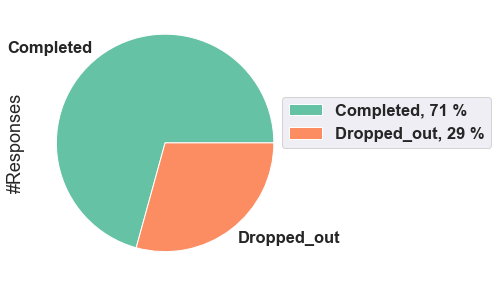

In [408]:
dfR = df['#Responses'].copy()
dfR[(dfR!=0)&(dfR!=60)]='Dropped_out'
# dfR[dfR==0]='Unanswered'
dfR[dfR==60]='Completed'
dfr = dfR[dfR!=0].value_counts().to_frame()
piep = dfr.plot.pie( y = '#Responses' ,figsize=(5, 5),colors = sns.color_palette("Set2", 3),pctdistance= 0.1)
plt.legend( bbox_to_anchor=(0.9,.7),loc = 'left', labels=['%s, %1.f %%' % (l, s) for l, s in zip(dfr.index, 100*dfr.iloc[:,0]/dfr.sum(axis=0).values)])
perc = (df['#Responses'].value_counts()[0]/df['#Responses'].value_counts().sum()*100).copy()
print('{}% of employees have left the entire survay blank.'.format(int(perc)))
perc = (df['#Responses'].value_counts()[2:].sum()/df['#Responses'].value_counts().sum()*100).copy()

print('{}% of employees have not compeleted the entire survay.'.format(int(np.round(perc,0))))
plt.show()

In [406]:
dfr

,#Responses
0,154970
Completed,143360
Dropped_out,59362


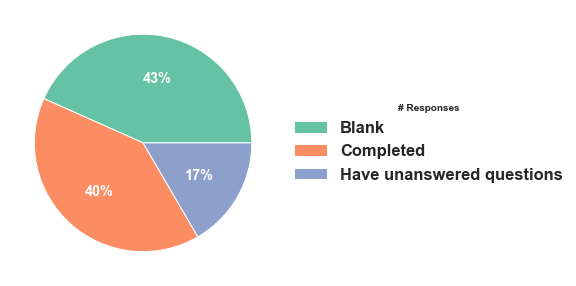

In [459]:
dfR = df['#Responses'].copy()
dfR[(dfR!=0)&(dfR!=60)]='Dropped_out'
dfR[dfR==0]='Unanswered'
dfR[dfR==60]='Completed'
dfr = dfR.value_counts().to_frame()


fig,ax=plt.subplots(1,1, figsize=(5, 5))
wedges, texts, autotexts =  ax.pie(dfr,autopct='%.0f%%',colors = sns.color_palette("Set2", 3),pctdistance= 0.6,textprops={'size': 'x-large','color':"w"})
labels = ['Blank','Completed','Have unanswered questions']
ax.legend(wedges, labels,
          title="# Responses",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          frameon = 0)




plt.show()

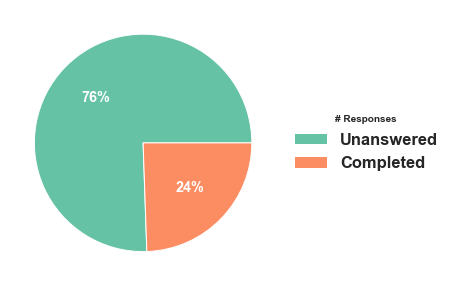

In [210]:
dfR = df['ti_unique_score'].copy()
dfR[dfR!=0] = 'Commented'
dfR[dfR==0] = 'Unanswered'

dfr = dfR.value_counts().to_frame()
fig,ax=plt.subplots(1,1, figsize=(5, 5))
wedges, texts, autotexts =  ax.pie(dfr,autopct='%.0f%%',colors = sns.color_palette("Set2", 3),pctdistance= 0.6,textprops={'size': 'x-large','color':"w"})
labels = ['Unanswered','Completed','Dropped_out']
ax.legend(wedges, labels,
          title="# Responses",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          frameon = 0)





# plt.legend( bbox_to_anchor=(0.9,.7),loc = 'left', labels=['%s, %1.f %%' % (l, s) for l, s in zip(dfr.index, 100*dfr.iloc[:,0]/dfr.sum(axis=0).values)])
plt.show()


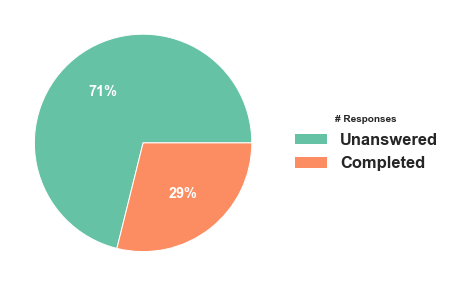

In [211]:
dfR = df['ti_change_score'].copy()
dfR[dfR!=0] = 'Commented'
dfR[dfR==0] = 'Unanswered'

dfr = dfR.value_counts().to_frame()
# piep = dfr.plot.pie( y = 'ti_change_score' ,figsize=(5, 5))
# plt.legend( bbox_to_anchor=(0.9,.7),loc = 'left', labels=['%s, %1.f %%' % (l, s) for l, s in zip(dfr.index, 100*dfr.iloc[:,0]/dfr.sum(axis=0).values)])
fig,ax=plt.subplots(1,1, figsize=(5, 5))
wedges, texts, autotexts =  ax.pie(dfr,autopct='%.0f%%',colors = sns.color_palette("Set2", 3),pctdistance= 0.6,textprops={'size': 'x-large','color':"w"})
labels = ['Unanswered','Completed','Dropped_out']
ax.legend(wedges, labels,
          title="# Responses",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          frameon = 0)

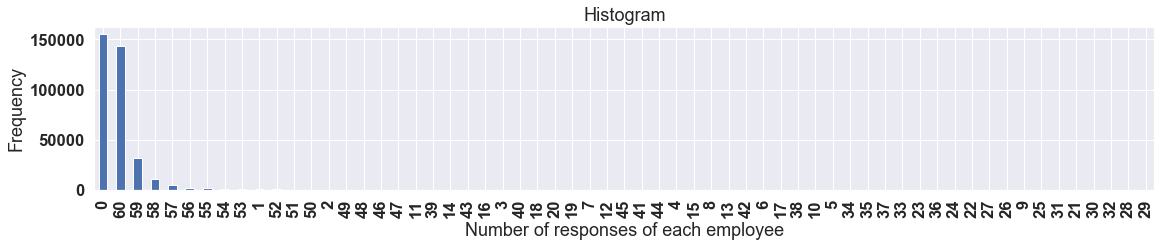

In [212]:
plt.figure(figsize=(19,3))
df['#Responses'].value_counts().plot(kind='bar')
plt.xlabel('Number of responses of each employee')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

> Most of the employees have either responded to all of the survey's 60 questions or have not responded to any.

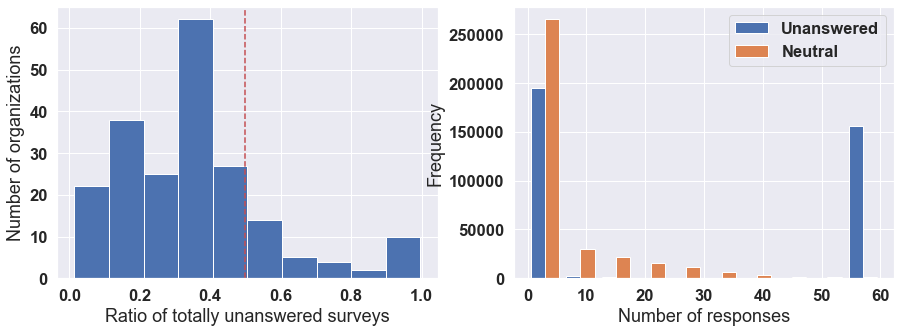

In [213]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

NR = df[df['#Responses']==0].groupby(['Survey' ])['#Responses'].count().copy()
R = df[df['#Responses']!=0].groupby(['Survey' ])['#Responses'].count().copy()
(NR/(NR+R)).hist(ax=ax[0])
ax[0].set_xlabel('Ratio of totally unanswered surveys')
ax[0].set_ylabel('Number of organizations')
ax[0].axvline(.5,linestyle='--',color='r')

s0 = (60-df['#Responses'])
s3 = df['ti_inconsistent']
ax[1].hist([s0,s3],label=['Unanswered', 'Neutral'])
ax[1].set_xlabel('Number of responses')
ax[1].set_ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

> **Left figure**: If we consider different locations of different organizations, we can see the ratio of unanswered questions is mostly > 0.5.<br>
**Right figure**: The mejority of people either response to all or no questions(Blue bars). Usually people don't choose 3 as an answer(Green bars). I believe this shows that it is not a good way to consider the unanswered questions as neutral responses.

In [214]:
# fig,ax = plt.subplots(1,2,figsize=(15,5))

# NR = df[df['#Responses']==0].groupby(['Survey' ])['#Responses'].count().copy()
# a = df[df['#Responses']==0]['Survey' ].unique()
# R = df.groupby(['Survey' ])['#Responses'].count().copy()
# plt.scatter(NR,R)

In [215]:
meanPR = dfq.groupby('Categories')['Q-Score'].mean().sort_values().copy()
dfmeanPR = pd.DataFrame(meanPR).reset_index()
dfmeanPR.columns = ['Categories','mean_Q-Score']
dfq = dfq.merge(dfmeanPR,right_on='Categories',left_on='Categories');

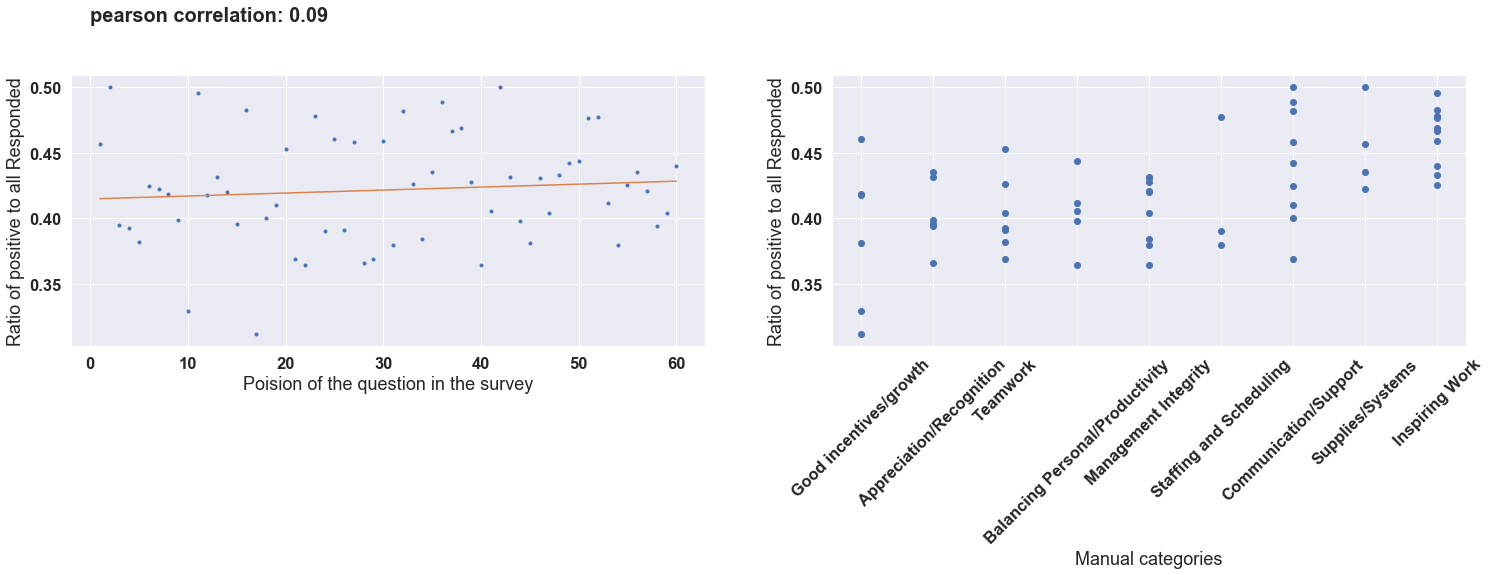

In [216]:
fig , ax = plt.subplots(1,2,figsize=(25,5))
ax[0].plot(dfq['Q_index'],dfq['Q-Score'],'.')
ax[0].plot(np.unique(dfq['Q_index']), np.poly1d(np.polyfit(dfq['Q_index'], dfq['Q-Score'], 1))(np.unique(dfq['Q_index'])))
ax[0].text(0,.55,"pearson correlation: "+str(round(np.corrcoef(dfq['Q_index'],dfq['Q-Score'])[0,1],2)),fontsize=20)
ax[0].set_xlabel('Poision of the question in the survey')
ax[0].set_ylabel('Ratio of positive to all Responded')
# ax[0].tick_params(labelrotation=45)

PR_Catg = dfq[['Categories','Q-Score','mean_Q-Score']].sort_values(by='mean_Q-Score')
ax[1].plot(PR_Catg.iloc[:,0],PR_Catg.iloc[:,1],'o')
ax[1].set_xlabel('Manual categories')
ax[1].set_ylabel('Ratio of positive to all Responded')
plt.xticks(rotation=45)
plt.show()

> **Left figure**: Score vs. Position of question in the survey. W can not see there is no correlation between the position of the question and the owerall score of the question.<br>
**Right figure**: This figure shows that in average, there is a correlation between the scores obtained by the questions in each category and the topic of categories.

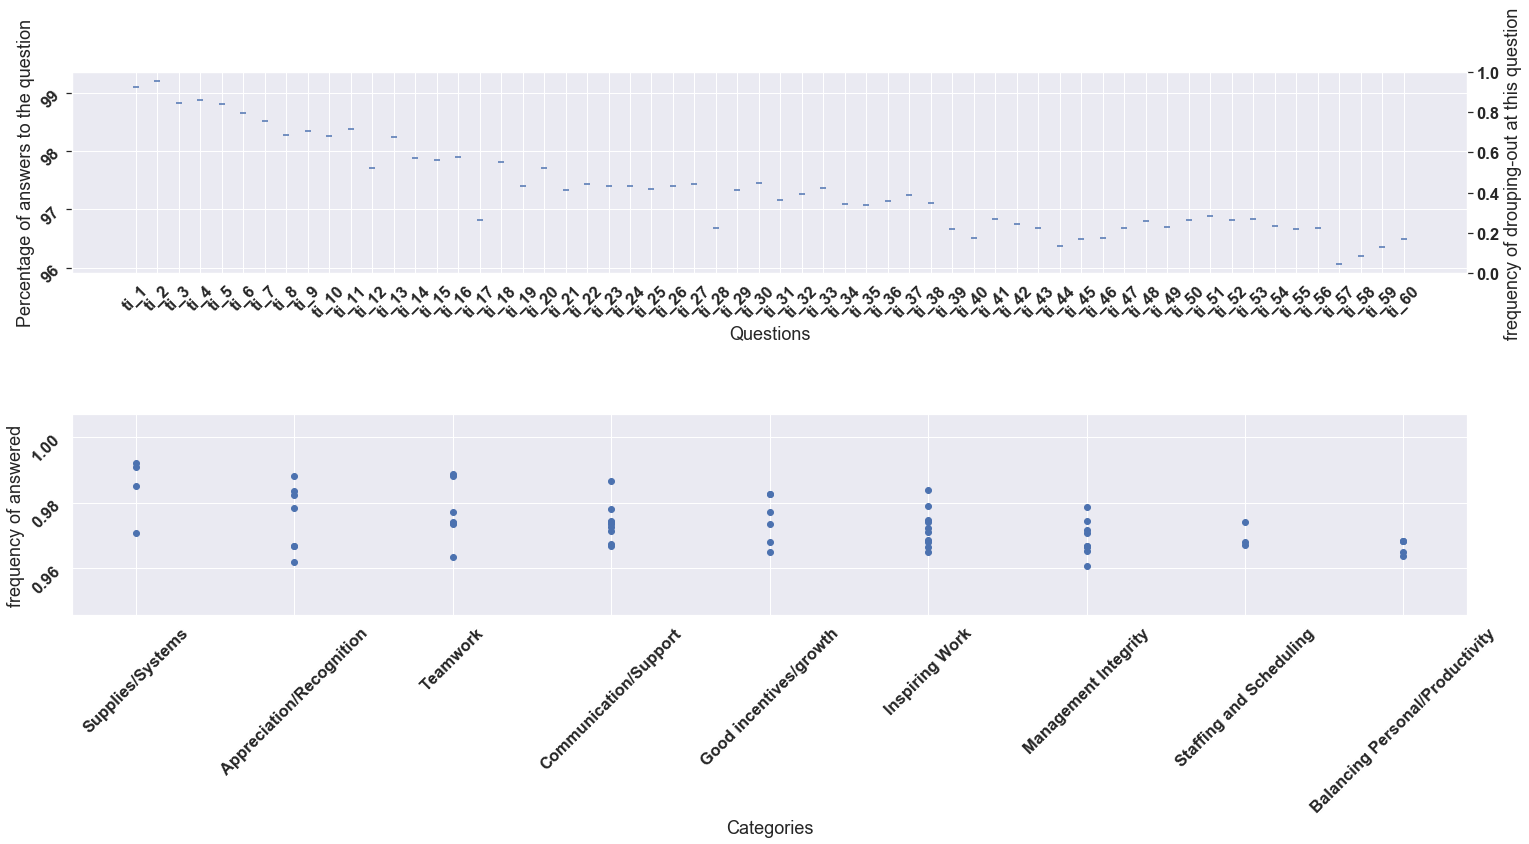

In [427]:
fig, ax = plt.subplots(2,1,figsize=(25,10))

ax00 = ax[0].twinx()
dfc = df[df['#Responses']!=0].iloc[:,5:65].astype(bool).mean(axis=0).to_frame('Answered').merge(dfq[['Questions','Categories']],left_index=True,right_on='Questions').copy()
dfd = df[df['#Responses']!=0]['LeftAt'].value_counts()
dfd.index = dfd.index.astype(int)
# ax00.scatter((dfd.index)-1,dfd.values,marker="_",c='r')
ax[0].scatter(x = dfc['Questions'] , y=dfc['Answered']*100,marker="_")
ax[0].set_xlabel('Questions')
ax[0].set_ylabel('Percentage of answers to the question')
ax[0].tick_params(labelrotation=45)
ax00.set_ylabel('frequency of drouping-out at this question')
ax00.grid(None)

ax[1].scatter(x = dfc['Categories'] , y=dfc['Answered'])
ax[1].set_xlabel('Categories')
ax[1].set_ylabel('frequency of answered')
ax[1].tick_params(labelrotation=45)

plt.subplots_adjust(hspace=.7)
plt.show()

> This figure shows people usually left the last questions unanswered.

## Data imputation:
>  Unanswered questions:<br>
1- Can be removed<br>
2- Can be considred as neutral response 3<br>
3- Can fill in by the mode of responses<br>
4- Creating dummy features and include unanswered questions as a feature<br>
>> - In this project, based on the results above, we remove all the employees how have left the suvey before question number 55.<br>
>>- We impute the unansweed questions of the rest of the employees with the most frequent answer of that employee.


In [218]:
df_imputed = df[(df['LeftAt']>55)][Qs].copy()
employee_mode = df_imputed.mode(axis=1)
df_imputed.replace(0,employee_mode,inplace=True)

In [219]:
df_imputed0 = df[(df['#Responses']>59)][Qs].copy()

corrmat = df_imputed0.corr()
Distance_Matrix = 1-corrmat

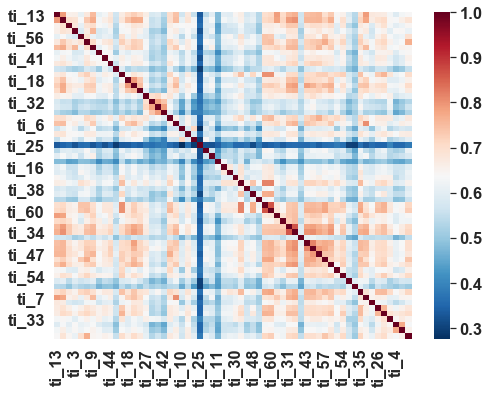

In [220]:
fig,ax =plt.subplots(1,1,figsize=(8,6))
sns.heatmap(corrmat,  cmap=pylab.cm.RdBu_r)


In [221]:
dfq[dfq['Actionable']==1][['Categories','Actionable','Text','Q-Score']].sort_values(by='Q-Score').head(60)

,Categories,Actionable,Text,Q-Score
30,Good incentives/growth,1,I feel I receive a fair share of the profits made by this organization.,0.311956
28,Good incentives/growth,1,People here are paid fairly for the work they do.,0.329236
44,Management Integrity,1,Managers avoid playing favorites.,0.364805
8,Appreciation/Recognition,1,Promotions go to those who best deserve them.,0.365700
21,Communication/Support,1,Management involves people in decisions that affect their jobs or work environment.,0.368876
54,Staffing and Scheduling,1,Management hires people who fit in well here.,0.379628
45,Management Integrity,1,Management delivers on its promises.,0.379774
32,Good incentives/growth,1,We have special and unique benefits here.,0.381149
46,Management Integrity,1,Management's actions match its words.,0.383981
52,Staffing and Scheduling,1,Management does a good job of assigning and coordinating people.,0.390635


## Target variable
>In this section, we are looking for a measure to label the data, to develop a supervised ML model for that.<br>

>- On option is the score of each person, that is the ratio of positive responses to the number of responded questions. The problem with this score is that there are some non-actionable questions in the survey and using these questions in the scoring system would not help to improve the results we are going to interpret from the ML model.<br>
>- base on the description above, one scoring system is the ratio of positive actionable responses to all of the actionable responses.<br>
>- Last question of the survey asked employees "Taking everything into account, I would say this is a great place to work". This qistion is also a good feature to be used as a target variable.

In [222]:
# fig , ax = plt.subplots(2,6,figsize=(35,5),sharex=True,sharey=True)

# for i in range(6):
#     sns.barplot(x=Qs, y=df[df['ti_60']==i][Qs].mean(),ax=ax[0,i])
#     sns.barplot(x=Qs, y=df[(df['E-Score']<=(i)*.2) & (df['E-Score']>(i-1)*.2)][Qs].mean(),ax=ax[1,i])

Text(0, 0.5, 'E-Score')

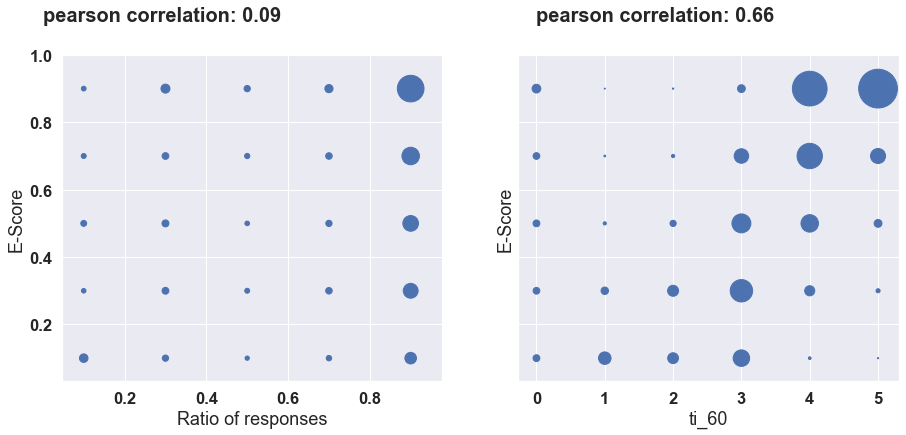

In [223]:
fig , ax = plt.subplots(1,2,figsize=(15,6),sharex=False,sharey=True)

X = (df['#Responses']/60).copy()
Y = (df['E-Score']).copy()
X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]

xedges = np.arange(0, np.max(X) ,.2)+.1
yedges = np.arange(0, np.max(Y) ,.2)+.1
meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
xedges = np.arange(0, np.max(X)+.2 ,.2) -.05
yedges = np.arange(0, np.max(Y)+.2 ,.2) -.05

H, _, _ = np.histogram2d(X, Y, bins=(xedges, yedges))
ax[0].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)/5)
ax[0].text(0,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=20)
ax[0].set_xlabel('Ratio of responses')
ax[0].set_ylabel('E-Score')

X = df['ti_60'].copy()
Y = df['E-Score'].copy()
X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]

xedges = np.arange(0, np.max(X) + 1,1)
yedges = np.arange(0, np.max(Y) ,.2)+.1
meshq = np.stack(np.meshgrid(xedges,yedges), -1).reshape(-1,2)
xedges = np.arange(0, np.max(X) + 1.5,1) -.5
yedges = np.arange(0, np.max(Y)+.2 ,.2) -.05

H, _, _ = np.histogram2d(X,Y, bins=(xedges, yedges))
ax[1].scatter(meshq[:,0], meshq[:,1], s=np.array(H.T).reshape(1,-1)/20)
ax[1].text(0,1.1,"pearson correlation: "+str(round(np.corrcoef(X,Y)[0,1],2)),fontsize=20)
ax[1].set_xlabel('ti_60')
ax[1].set_ylabel('E-Score')


> This figure shows:<br>
**Left figure:** There is no correlation between the number of responses and the finall score.<br>
**Middle figure:** There is a correlation between the finall score and employees response to the question they rank overally their workplace.<br>
**Right figure:** There is also a high correlation between the finall score and the actionable finall score.<br>

In [224]:
df['Target'] = df['E-Score']>np.median(df['E-Score'].dropna())

### Number of unique rows

In [225]:
df_rows = df.drop_duplicates()
df_rows.shape
df_rows = df.iloc[:,5:64].drop_duplicates()
df_rows.shape

(172879, 59)

## Machine learning model development

In [502]:
def ML_dev( X_train, y_train, ML_name):
    """
    input
    """
    pickle_key='ML_'+ML_name+'.pkl'
    path_pickle = '../../data/pickles/'
    pickle_location_AWS = 's3://{}/{}'.format(bucket, pickle_key)
    pickle_location_local = path_pickle+pickle_key


    try:
        if ~AWS:
            with open(pickle_location_local, 'rb') as file:
                XGB_GridSearch = pickle.load(file)
                file.close()
            print('Loading Model from pickle ...')
        else:
            response = s3client.get_object(Bucket=bucket, Key=pickle_key)
            body = response['Body'].read()
            XGB_GridSearch = pickle.loads(body)
            print('Loading pickle ...')            
    except:
        print('Training model ...')
        # Create training and validation sets
        estimator = xgb.XGBRegressor(random_state=2)
        
#         param_grid = {
#             'max_depth': [ 4, 5,7,10],
#             'n_estimators': [10, 50,100,200],
#             'min_samples_split':[5,8,10],
#         }
        param_grid = {
            'max_depth': [ 5],
            'n_estimators': [100],
            'min_samples_split':[5],
        }
        XGB_GridSearch = GridSearchCV(estimator, param_grid, cv=5,n_jobs=-1,verbose=10)
        XGB_GridSearch.fit(X_train, y_train)
        if ~AWS:
            pickle.dump(XGB_GridSearch, open(pickle_location_local, 'wb'))
            print('Storing pickle ...')            

        else:
            print('Storing pickle ...')            
            pickle.dump(XGB_GridSearch, open(pickle_location_AWS, 'wb'))
            s3_resource = boto3.resource('s3')
            s3_resource.Object(bucket,pickle_name).put(Body=open(pickle_name, 'rb'))
    return XGB_GridSearch

### ML on all of the questions

> In this sesction I am going to apply the RandomForest Classifier, to find the most important questions that can predict the actionable score.

In [151]:
# Prepare the data
df_imputed = df[(df['#Responses']>59)][Qs].copy()
# df_0 = df_imputed.copy()
# df_1 = df[(df['#Responses']>59)].loc[:,['LeftAt']].copy()
# x = pd.merge(df_0,df_1,right_index=True,left_index=True)
x = df_imputed.copy()
y = df[(df['#Responses']>59)].loc[:,'E-Score'].copy()
# Create training and validation sets
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)
XGB_all_Qs = ML_dev(X_train, y_train,'_all_Qs')

Training model ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   54.2s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   54.5s remaining:   36.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


[13:32:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Storing pickle ...


In [152]:
print('Best parameters found by grid search are:', XGB_all_Qs.best_params_)
y_predict = XGB_all_Qs.best_estimator_.predict(X_train)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_train = XGB_all_Qs.best_estimator_.score(X_train,y_predict)

y_predict = XGB_all_Qs.best_estimator_.predict(X_test)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_test = XGB_all_Qs.best_estimator_.score(X_test,y_predict)

print('The mean squared error for the random forest model:')
print('on the train dataset is: ',mean_squared_error(XGB_all_Qs.best_estimator_.predict(X_train),y_train))
print('on the test dataset is: ',mean_squared_error(XGB_all_Qs.best_estimator_.predict(X_test),y_test))
print('The pearson correlation coefficient between the predicted and real score:')
print('on the train dataset is: ',np.corrcoef(XGB_all_Qs.best_estimator_.predict(X_train),y_train)[0,1])
print('on the test dataset is: ',np.corrcoef(XGB_all_Qs.best_estimator_.predict(X_test),y_test)[0,1])

Best parameters found by grid search are: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
The mean squared error for the random forest model:
on the train dataset is:  0.00018429933163762095
on the test dataset is:  0.00022455853694511226
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.998881083257618
on the test dataset is:  0.9986507455374849


Feature ranking:


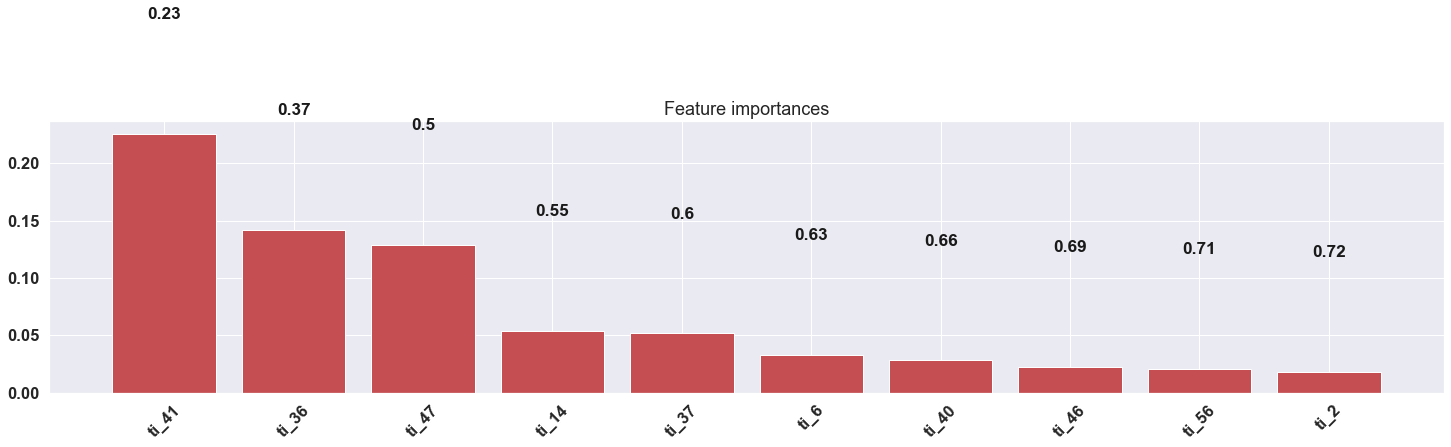

In [153]:
features = dfq[['Questions', "Q_index"]].sort_values(by = 'Q_index', ascending=True).iloc[:,0].values
# features=np.append(features,['LeftAt'])
importances= XGB_all_Qs.best_estimator_.feature_importances_

# std = np.std([tree.feature_importances_ for tree in RF.estimators_],
#              axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(25,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1])[:10], importances[indices][:10],
        color="r", align="center")
# plt.xlim([-1, X.shape[1]])
plt.xticks(range(len(indices))[:10], features[indices][:10])
plt.xticks(rotation=45)
pos = range(X_train.shape[1])[:10]
perc = importances[indices]
cumsum_perc = np.cumsum(importances[indices]).round(2)
for tick in pos:
    plt.text(pos[tick], perc[tick] + .1, cumsum_perc[tick], horizontalalignment='center', size='xx-large', color='k', weight='semibold')

plt.show()


In [154]:
dfq.sort_values(by = 'Q_index', ascending=True,inplace=True)

dfq.iloc[indices,:][['Questions','Actionable','Text']]


,Questions,Actionable,Text
56,ti_41,1,People are encouraged to balance their work life and their personal life.
24,ti_36,1,People here are treated fairly regardless of their gender.
50,ti_47,1,"Management shows a sincere interest in me as a person, not just an employee."
43,ti_14,1,Management recognizes honest mistakes as part of doing business.
37,ti_37,0,I'm proud to tell others I work here.
18,ti_6,1,Management makes its expectations clear.
55,ti_40,0,People avoid politicking and backstabbing as ways to get things done.
49,ti_46,1,Management is honest and ethical in its business practices.
9,ti_56,0,"Our customers would rate the service we deliver as ""excellent."""
1,ti_2,1,This is a physically safe place to work.


### ML on actionable questions

In [242]:
df_imputed = df[(df['#Responses']>59)][Qs].copy()

x = df_imputed[aQs].copy()
y = df[(df['#Responses']>59)].loc[:,'E-Score'].copy()
# Create training and validation sets

In [243]:
# Create training and validation sets
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)
XGB_actionable_Qs = ML_dev(X_train, y_train,'_actionable_questions')

Loading Model from pickle ...


In [244]:
print('Best parameters found by grid search are:', XGB_actionable_Qs.best_params_)
y_predict = XGB_actionable_Qs.best_estimator_.predict(X_train)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_train = XGB_actionable_Qs.best_estimator_.score(X_train,y_predict)

y_predict = XGB_actionable_Qs.best_estimator_.predict(X_test)
y_predict[y_predict<0]=0
y_predict[y_predict>1]=1
R2_test = XGB_actionable_Qs.best_estimator_.score(X_test,y_predict)

print('The mean squared error for the random forest model:')
print('on the train dataset is: ',mean_squared_error(XGB_actionable_Qs.best_estimator_.predict(X_train),y_train))
print('on the test dataset is: ',mean_squared_error(XGB_actionable_Qs.best_estimator_.predict(X_test),y_test))
print('The pearson correlation coefficient between the predicted and real score:')
print('on the train dataset is: ',np.corrcoef(XGB_actionable_Qs.best_estimator_.predict(X_train),y_train)[0,1])
print('on the test dataset is: ',np.corrcoef(XGB_actionable_Qs.best_estimator_.predict(X_test),y_test)[0,1])


Best parameters found by grid search are: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
The mean squared error for the random forest model:
on the train dataset is:  0.0007182713873753506
on the test dataset is:  0.000851498091125446
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.9956262459263723
on the test dataset is:  0.9948666403025339


Feature ranking:


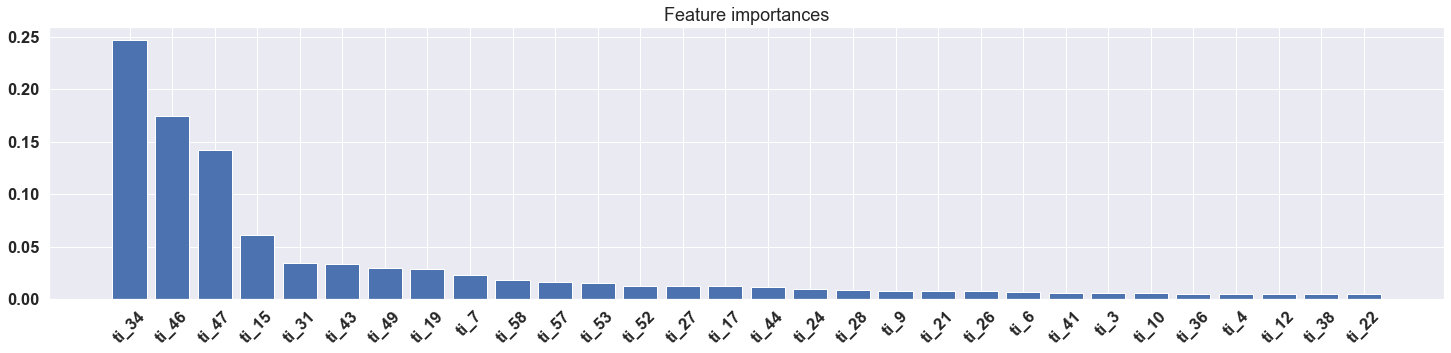

In [503]:
features = dfq[dfq['Questions'].isin(aQs)][['Questions', "Q_index"]].sort_values(by = 'Q_index', ascending=True).iloc[:,0].values
# features=np.append(feature,['#Responses','LeftAt'])
importances= XGB_actionable_Qs.best_estimator_.feature_importances_

# std = np.std([tree.feature_importances_ for tree in RF.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(25,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1])[:30], importances[indices][:30], )
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.xticks(range(len(indices))[:30], features[indices][:30])
plt.xticks(rotation=45)

pos = range(X_train.shape[1])[:30]
perc = importances[indices]
cumsum_perc = np.cumsum(importances[indices]).round(2)
# for tick in pos:
#     plt.text(pos[tick], perc[tick] + 0.025, cumsum_perc[tick], horizontalalignment='center', size='xx-large', color='k', weight='semibold')
plt.show()

In [504]:
dfq.sort_values(by = 'Q_index', ascending=True,inplace=True)
dfq1 = dfq[dfq['Questions'].isin(aQs)].iloc[indices,:][['Q_index','Questions','Actionable','Text']].copy()
pickle_key = 'Important_questions.pkl'
pickle_location_local = path_pickle+pickle_key
if AWS:
    dfq1.to_pickle(pickle_key)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(bucket,pickle_key).put(Body=open(pickle_key, 'rb'))
else:
    dfq1.to_pickle(pickle_location_local)  
dfq1

,Q_index,Questions,Actionable,Text
46,34,ti_34,1,Management's actions match its words.
49,46,ti_46,1,Management is honest and ethical in its business practices.
50,47,ti_47,1,"Management shows a sincere interest in me as a person, not just an employee."
7,15,ti_15,1,Management genuinely seeks and responds to suggestions and ideas.
45,31,ti_31,1,Management delivers on its promises.
48,43,ti_43,1,Management is competent at running the business.
26,49,ti_49,1,I am treated as a full member here regardless of my position.
20,19,ti_19,1,Management has a clear view of where the organization is going and how to get there.
2,7,ti_7,1,I can ask management any reasonable question and get a straight answer.
10,58,ti_58,1,"We celebrate people who try new and better ways of doing things, regardless of the outcome."


In [247]:
dfq[dfq['Questions'].isin(aQs)].iloc[indices,:]['Categories'][:10].value_counts()

Management Integrity        5
Appreciation/Recognition    2
Communication/Support       2
Supplies/Systems            1
Name: Categories, dtype: int64

In [248]:
set(dfq[dfq['Questions'].isin(aQs)].iloc[indices,:]['Categories'].unique())-set(dfq[dfq['Questions'].isin(aQs)].iloc[indices,:]['Categories'][:10].unique())


{'Balancing Personal/Productivity',
 'Good incentives/growth',
 'Inspiring Work',
 'Staffing and Scheduling',
 'Teamwork'}

In [249]:
# df[df[col_list]>3][col_list] = 'Positive'
# df[df[col_list]==3][col_list] = 'Neutral'
# df[(df[col_list]<3)&(df[col_list]!=0)][col_list] = 'Negative'
# df[df[col_list]==0][col_list] = 'Unanswered'

In [250]:
# importantfeatures = [33,42,56,8,48,53,25,21,51,16];

In [251]:
# dfq.iloc[importantfeatures,:][['Questions','Actionable','Text']]


## Machine learning model development
### on binerized 10 most important questions

In [252]:
# # dummy variables based on nested trust indicies.
# dummy_aQs = []

# cols = aQs[indices[:10]]
# new_col = list(map(lambda x:str(x)+'_positive',cols))
# df[new_col]  = df[cols]>3
# dummy_aQs = dummy_aQs+new_col

# new_col = list(map(lambda x:str(x)+'_negative',cols))
# df[new_col]  = ((df[cols]<3) & (df[cols]!=0))
# dummy_aQs = dummy_aQs+new_col

# new_col = list(map(lambda x:str(x)+'_neutral',cols))
# df[new_col]  = df[cols]==3
# dummy_aQs = dummy_aQs+new_col

# new_col = list(map(lambda x:str(x)+'_unanswered',cols))
# df[new_col]  = df[cols]==0
# dummy_aQs = dummy_aQs+new_col


In [320]:
features = dfq1['Questions'][:10]
df_important = df[df['#Responses']>55].loc[:,df.columns.isin(features)].copy()
df_important = pd.get_dummies(df_important, columns = features)
df_important['E-Score'] = df[df['#Responses']>55].loc[:,'E-Score']
df_important[escat] = df[df['#Responses']>55].loc[:,escat]




In [321]:
df_important

,ti_34_0,ti_34_1,ti_34_2,ti_34_3,ti_34_4,ti_34_5,ti_46_0,ti_46_1,ti_46_2,ti_46_3,...,E-Score,E-Score-Supplies/Systems,E-Score-Appreciation/Recognition,E-Score-Teamwork,E-Score-Communication/Support,E-Score-Good incentives/growth,E-Score-Inspiring Work,E-Score-Management Integrity,E-Score-Staffing and Scheduling,E-Score-Balancing Personal/Productivity
0,0,0,0,1,0,0,0,1,0,0,...,0.150000,0.75,0.000000,0.000000,0.333333,0.166667,0.1,0.000000,0.333333,0.0
1,0,0,0,0,0,1,0,0,0,0,...,0.983333,1.00,1.000000,1.000000,1.000000,1.000000,1.0,0.888889,1.000000,1.0
3,0,0,0,0,0,1,0,0,0,0,...,0.900000,0.75,1.000000,0.857143,0.888889,0.666667,1.0,0.888889,1.000000,1.0
4,0,0,0,0,0,1,0,0,0,0,...,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0
6,0,1,0,0,0,0,0,1,0,0,...,0.017544,0.25,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357687,0,0,0,1,0,0,0,0,0,1,...,0.100000,0.00,0.000000,0.000000,0.111111,0.000000,0.3,0.000000,0.333333,0.2
357688,0,0,0,1,0,0,0,0,0,0,...,0.750000,0.75,0.714286,0.857143,0.777778,0.500000,0.9,0.666667,0.666667,0.8
357689,0,0,0,0,0,1,0,0,0,0,...,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0
357690,0,0,0,0,1,0,0,0,0,0,...,0.983333,1.00,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.8


In [471]:
# Prepare the data
dummy_aQs = ~df_important.columns.isin(escat.tolist()+['E-Score'])
x = df_important.loc[:,dummy_aQs ].copy()
y = df_important.loc[:,'E-Score'].copy()
#Create training and validation sets
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)
XGB_overall_score = ML_dev( X_train, y_train,'_overall_score')
print('Best parameters found by grid search are:', XGB_overall_score.best_params_)

Training model ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   41.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


[19:10:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Storing pickle ...
Best parameters found by grid search are: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}


In [505]:
mse_train_General = mean_squared_error(XGB_overall_score.best_estimator_.predict(X_train),y_train)
mse_test_General = mean_squared_error(XGB_overall_score.best_estimator_.predict(X_test),y_test)
print('The mean squared error for the Gradient Boosting model:')
print('on the train dataset is: ',mean_squared_error(XGB_overall_score.best_estimator_.predict(X_train),y_train))
print('on the test dataset is: ',mean_squared_error(XGB_overall_score.best_estimator_.predict(X_test),y_test))
print('The pearson correlation coefficient between the predicted and real score:')
print('on the train dataset is: ',np.corrcoef(XGB_overall_score.best_estimator_.predict(X_train),y_train)[0,1])
print('on the test dataset is: ',np.corrcoef(XGB_overall_score.best_estimator_.predict(X_test),y_test)[0,1])


The mean squared error for the Gradient Boosting model:
on the train dataset is:  0.00565333006957572
on the test dataset is:  0.005933587653751673
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.9653968158278209
on the test dataset is:  0.9635083645499259


In [349]:
df_important.columns[dummy_aQs].values

array(['ti_34_0', 'ti_34_1', 'ti_34_2', 'ti_34_3', 'ti_34_4', 'ti_34_5',
       'ti_46_0', 'ti_46_1', 'ti_46_2', 'ti_46_3', 'ti_46_4', 'ti_46_5',
       'ti_47_0', 'ti_47_1', 'ti_47_2', 'ti_47_3', 'ti_47_4', 'ti_47_5',
       'ti_15_0', 'ti_15_1', 'ti_15_2', 'ti_15_3', 'ti_15_4', 'ti_15_5',
       'ti_31_0', 'ti_31_1', 'ti_31_2', 'ti_31_3', 'ti_31_4', 'ti_31_5',
       'ti_43_0', 'ti_43_1', 'ti_43_2', 'ti_43_3', 'ti_43_4', 'ti_43_5',
       'ti_49_0', 'ti_49_1', 'ti_49_2', 'ti_49_3', 'ti_49_4', 'ti_49_5',
       'ti_19_0', 'ti_19_1', 'ti_19_2', 'ti_19_3', 'ti_19_4', 'ti_19_5',
       'ti_7_0', 'ti_7_1', 'ti_7_2', 'ti_7_3', 'ti_7_4', 'ti_7_5',
       'ti_58_0', 'ti_58_1', 'ti_58_2', 'ti_58_3', 'ti_58_4', 'ti_58_5'],
      dtype=object)

Feature ranking:


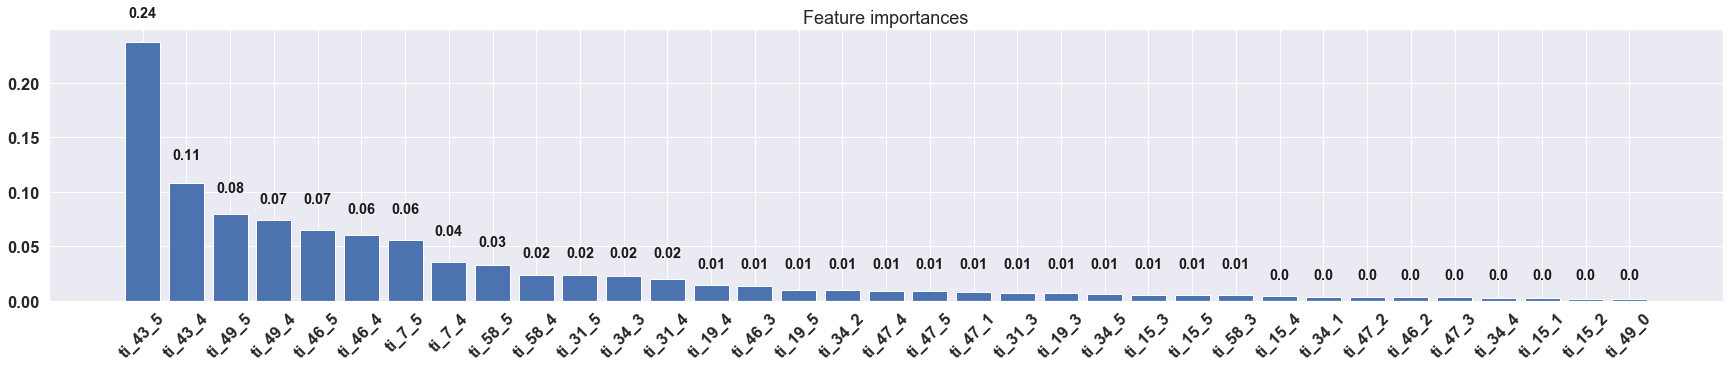

In [350]:
features = df_important.columns[dummy_aQs].values
importances= XGB_overall_score.best_estimator_.feature_importances_

# std = np.std([tree.feature_importances_ for tree in RF.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
ii = 35 
# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(30,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1])[:ii], importances[indices][:ii], )
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.xticks(range(len(indices))[:ii], features[indices][:ii])
plt.xticks(rotation=45)

pos = range(X_train.shape[1])[:ii]
perc = importances[indices].round(2)
cumsum_perc = np.cumsum(importances[indices]).round(2)
for tick in pos:
    plt.text(pos[tick], perc[tick] + .02, perc[tick], horizontalalignment='center', size='x-large', color='k', weight='semibold')
plt.show()

## Develop ML models to predict categories scores

In [515]:
mse_test = []
mse_train = []
for i,cat in enumerate(qcategories):
    print(cat)
    x = df_important.loc[:,dummy_aQs].copy()
    y = df_important.loc[:,escat[i]].copy()
    # Create training and validation sets
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)
    model_cat = ML_dev(X_train, y_train,'Category'+str(i))

    mse_train.append(mean_squared_error(model_cat.best_estimator_.predict(X_train),y_train))
    mse_test.append(mean_squared_error(model_cat.best_estimator_.predict(X_test),y_test))
    print('The mean squared error for the Gradient Boosting model:')
    print('on the train dataset is: ',mean_squared_error(model_cat.best_estimator_.predict(X_train),y_train))
    print('on the test dataset is: ',mean_squared_error(model_cat.best_estimator_.predict(X_test),y_test))
    print('The pearson correlation coefficient between the predicted and real score:')
    print('on the train dataset is: ',np.corrcoef(model_cat.best_estimator_.predict(X_train),y_train)[0,1])
    print('on the test dataset is: ',np.corrcoef(model_cat.best_estimator_.predict(X_test),y_test)[0,1])
    
    

Supplies/Systems
Loading Model from pickle ...
The mean squared error for the Gradient Boosting model:
on the train dataset is:  0.019410050932884004
on the test dataset is:  0.020546413136284535
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.8854017838031473
on the test dataset is:  0.8768818391203865
Appreciation/Recognition
Loading Model from pickle ...
The mean squared error for the Gradient Boosting model:
on the train dataset is:  0.012384454071678774
on the test dataset is:  0.012802563670094054
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.9465027623896304
on the test dataset is:  0.9446201910935808
Teamwork
Loading Model from pickle ...
The mean squared error for the Gradient Boosting model:
on the train dataset is:  0.028201152848173816
on the test dataset is:  0.029188609790711573
The pearson correlation coefficient between the predicted and real score:
on the train

In [514]:
['General']+list(qcategories)
print()


[0.00565333006957572, 0.00565333006957572, 0.00565333006957572, 0.019410050932884004, 0.012384454071678774, 0.028201152848173816, 0.010570949130257645, 0.032055602386799026, 0.01866526670637432, 0.005403919656089579, 0.03279691043264203, 0.029041643878699824]


In [518]:
mse_train.insert(0,mse_train_General)
mse_test.insert(0,mse_test_General)

[0.00565333006957572,
 0.019410050932884004,
 0.012384454071678774,
 0.028201152848173816,
 0.010570949130257645,
 0.032055602386799026,
 0.01866526670637432,
 0.005403919656089579,
 0.03279691043264203,
 0.029041643878699824]

In [519]:
dfmse = pd.DataFrame({'Categories':['General']+list(qcategories),'Train':mse_train,'Test':mse_test})





In [520]:
dfmse.iloc[:,1:3]=np.round(dfmse.iloc[:,1:3]*100,1)
dfmse

,Categories,Train,Test
0,General,0.6,0.6
1,Supplies/Systems,1.9,2.1
2,Appreciation/Recognition,1.2,1.3
3,Teamwork,2.8,2.9
4,Communication/Support,1.1,1.1
5,Good incentives/growth,3.2,3.3
6,Inspiring Work,1.9,2.0
7,Management Integrity,0.5,0.6
8,Staffing and Scheduling,3.3,3.4
9,Balancing Personal/Productivity,2.9,3.0


## Develop ML models to predict inconsistancy score

In [381]:
dummy_aQs

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False])

In [387]:
mse_test_5 = []
mse_train_5 = []
np.random.seed(1)
import random
for i in range(12):
    print(i)
    # dummy variables based on nested trust indicies.
#     dummy_aQs = []
#     most_imortant_aQs =  aQs[indices[:10]].copy()

#     cols = np.random.choice(most_imortant_aQs,5,replace=False)
#     print(cols)
#     new_col = list(map(lambda x:str(x)+'_positive',cols))
#     df_imputed[new_col]  = df_imputed[cols]>3
#     dummy_aQs = dummy_aQs+new_col

#     new_col = list(map(lambda x:str(x)+'_negative',cols))
#     df_imputed[new_col]  = ((df_imputed[cols]<3) & (df_imputed[cols]!=0))
#     dummy_aQs = dummy_aQs+new_col

#     new_col = list(map(lambda x:str(x)+'_neutral',cols))
#     df_imputed[new_col]  = df_imputed[cols]==3
#     dummy_aQs = dummy_aQs+new_col

#     new_col = list(map(lambda x:str(x)+'_unanswered',cols))
#     df_imputed[new_col]  = df_imputed[cols]==0
#     dummy_aQs = dummy_aQs+new_col
    cols0 = random.sample(range(10),5)
    print(sorted(cols0))
    rand_indices = [list(range(c*6,c*6+6)) for c in sorted(cols0)]
    rand_indices = sum(rand_indices,[])
#     print(sum(rand_indices,[]))
#     dummy_aQs[rand_indices]

#     print(dummy_aQs[rand_indices])
    x = df_important.iloc[:,rand_indices].copy()
    y = df_important.loc[:,'E-Score'].copy()
    # Create training and validation sets
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)
    model_rand = ML_dev(X_train, y_train,'Rand_'+str(i))
    
    mse_train_5.append(mean_squared_error(model_rand.best_estimator_.predict(X_train),y_train))
    mse_test_5.append(mean_squared_error(model_rand.best_estimator_.predict(X_test),y_test))
    print('The mean squared error for the Gradient Boosting model:')
    print('on the train dataset is: ',mean_squared_error(model_rand.best_estimator_.predict(X_train),y_train))
    print('on the test dataset is: ',mean_squared_error(model_rand.best_estimator_.predict(X_test),y_test))
    print('The pearson correlation coefficient between the predicted and real score:')
    print('on the train dataset is: ',np.corrcoef(model_rand.best_estimator_.predict(X_train),y_train)[0,1])
    print('on the test dataset is: ',np.corrcoef(model_rand.best_estimator_.predict(X_test),y_test)[0,1])
    
    

0
[1, 3, 6, 7, 8]
Training model ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   42.0s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   42.0s remaining:   28.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.8s finished


[16:22:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Storing pickle ...
The mean squared error for the Gradient Boosting model:
on the train dataset is:  0.00916720643255804
on the test dataset is:  0.009398500232085277
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.9432494825345373
on the test dataset is:  0.9415604484307878
1
[0, 2, 5, 8, 9]
Training model ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   36.1s remaining:   54.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   36.7s remaining:   24.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.8s finished


[16:23:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Storing pickle ...
The mean squared error for the Gradient Boosting model:
on the train dataset is:  0.00887425737000984
on the test dataset is:  0.009032246505170982
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.9451157665772328
on the test dataset is:  0.9438897267687635
2
[1, 2, 4, 8, 9]
Training model ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   33.1s remaining:   49.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   33.1s remaining:   22.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.5s finished


[16:24:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Storing pickle ...
The mean squared error for the Gradient Boosting model:
on the train dataset is:  0.008921498042040078
on the test dataset is:  0.009046753997318519
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.944815087801578
on the test dataset is:  0.9437936223510458
3
[1, 4, 7, 8, 9]
Training model ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   33.1s remaining:   49.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   33.4s remaining:   22.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.7s finished


[16:25:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Storing pickle ...
The mean squared error for the Gradient Boosting model:
on the train dataset is:  0.0089739445105291
on the test dataset is:  0.009128132172921249
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.944481139480971
on the test dataset is:  0.9432743688118075
4
[1, 2, 3, 4, 7]
Training model ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   33.4s remaining:   50.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   33.4s remaining:   22.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.9s finished


[16:26:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Storing pickle ...
The mean squared error for the Gradient Boosting model:
on the train dataset is:  0.009340572726180541
on the test dataset is:  0.009453372715996207
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.9421434020452192
on the test dataset is:  0.9411948052534902
5
[0, 3, 6, 7, 8]
Training model ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   38.5s remaining:   57.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   38.7s remaining:   25.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.9s finished


[16:27:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Storing pickle ...
The mean squared error for the Gradient Boosting model:
on the train dataset is:  0.009259059849209978
on the test dataset is:  0.009461034494338483
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.9426636270970743
on the test dataset is:  0.9411591393789669
6
[0, 2, 3, 6, 7]
Training model ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   33.0s remaining:   49.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   33.0s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.1s finished


[16:28:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Storing pickle ...
The mean squared error for the Gradient Boosting model:
on the train dataset is:  0.008701896046510232
on the test dataset is:  0.008851474669058302
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.9462120932736904
on the test dataset is:  0.9450539874435563
7
[0, 2, 4, 5, 6]
Training model ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   32.4s remaining:   48.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   32.4s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.6s finished


[16:29:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Storing pickle ...
The mean squared error for the Gradient Boosting model:
on the train dataset is:  0.009138538124271409
on the test dataset is:  0.009355075488281808
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.9434323104071286
on the test dataset is:  0.9418226209125885
8
[1, 4, 5, 7, 8]
Training model ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   35.2s remaining:   52.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   35.4s remaining:   23.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.9s finished


[16:30:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Storing pickle ...
The mean squared error for the Gradient Boosting model:
on the train dataset is:  0.010448007968341475
on the test dataset is:  0.010728710680305875
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.9350464995733782
on the test dataset is:  0.932974733413858
9
[0, 1, 2, 6, 8]
Training model ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   32.1s remaining:   48.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   32.2s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.0s finished


[16:31:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Storing pickle ...
The mean squared error for the Gradient Boosting model:
on the train dataset is:  0.009341295151092686
on the test dataset is:  0.009684591813001108
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.9421387777473841
on the test dataset is:  0.9397156533942446
10
[1, 2, 5, 6, 8]
Training model ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   32.6s remaining:   49.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   32.8s remaining:   21.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.0s finished


[16:32:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Storing pickle ...
The mean squared error for the Gradient Boosting model:
on the train dataset is:  0.009895309553693192
on the test dataset is:  0.010179817357476946
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.9385950866592324
on the test dataset is:  0.936521535714933
11
[1, 2, 4, 5, 6]
Training model ...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   32.3s remaining:   48.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   32.6s remaining:   21.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.3s finished


[16:33:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Storing pickle ...
The mean squared error for the Gradient Boosting model:
on the train dataset is:  0.00926545857378064
on the test dataset is:  0.009480033559102126
The pearson correlation coefficient between the predicted and real score:
on the train dataset is:  0.9426228157079026
on the test dataset is:  0.9410247981982706


[4, 1, 7, 5, 6, 0, 9, 2, 8, 3]

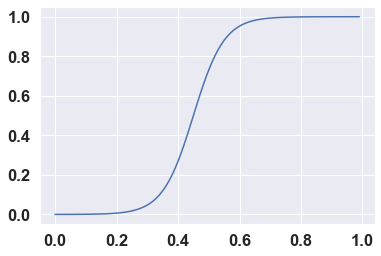

In [457]:
# x= np.arange(0,1,.01)
# plt.plot(x,(1+np.exp(-(x-.45)*20))**-1)
# # np.random.randint(10, 2)


In [392]:
x = np.zeros([5,4])
x=x.T.reshape(1,-1)
x =[int(i) for i in '1111001111000000000']
directory_name='../../data/pickles/'
np.random.seed(1)
resultm = np.zeros(12)
for i in range(12):
    print(i)
    pickle_name = 'ML_Rand_'+str(i)+'.pkl'
    loaded_model = pickle.load(open(directory_name+pickle_name, 'rb'))
    dummy_aQs = loaded_model.best_estimator_.get_booster().feature_names
    dfx = pd.DataFrame(x,columns=dummy_aQs)

    
    resultm[i] = loaded_model.best_estimator_.predict(dfx)
# resultm
# dfm = pd.DataFrame(data=np.round(resultm*100,1),index=np.insert(qcategories,0,'Overall')).reset_index()
# dfm.columns=['Categories','percentage']
# dfm1 = dfr[dfr['Categories']!='Overall'].sort_values(by='percentage')
# dfm1 = dfm1.append(dfm[dfm['Categories']=='Overall'])


0


ValueError: Shape of passed values is (19, 1), indices imply (19, 30)

In [ ]:
plt.hist(resultm*100)

In [ ]:
mse_train_5

In [ ]:
dfmse_5 = pd.DataFrame({'ML#':range(12),'Train':mse_train_5,'Test':mse_test_5})
dfmse_5.iloc[:,1:3]=np.round(dfmse_5.iloc[:,1:3]*100,1)
dfmse_5

In [ ]:
result = np.array([.1,.2,.3,.4,.5,.6,.6,.7,.8,.9,1])#np.random.random(10)#;

dfr = pd.DataFrame(data=np.round(result*100,1))

zz = (dfr//10).iloc[:,0].values.astype(int).tolist()
print(zz)
# import plotly.express as px
colorz = px.colors.diverging.RdYlGn
colorz = np.array(colorz)[zz]

colorz =[str(i) for i in colorz]

fig = px.bar(x=dfr.iloc[:,0],y=dfr.index.values,orientation='h')
fig.update_traces(marker_color=colorz)
fig.update_layout(
    title="Predicted",
    xaxis_title="Score(%)",
    yaxis_title="Categories",
    font=dict(
        size=18,
        color="#7f7f7f"
    )
)